# 1. Introduction
This notebook is used to process the raw data in order to obtain labelled images for training in a deep learning network. The order of steps is as follows:
1. Replace the "banners" in the images by using reflective padding 
2. Apply the watershed algorithm to the image in order to obtain markers for the segments in the image and save them to the Processed_Data subdirectory
3. After manually determining which images have been successfully labelled using the watershed algorithm, move them into a new subdirectory and use ImageJ to segment the unsuccesfully labelled images

# 2. Import Libraries and Define Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time as time

from scipy.ndimage import label
from skimage.feature import peak_local_max
from skimage.morphology import watershed

from pathlib import Path

In [2]:
def reflective_pad(img, remove_box):
    """
    Replaces "remove_box" in the img with reflective padding. The "remove_box" input is an array the same size 
    as img but with all 0's in the region where the banner is.
    """
    banner = np.argwhere(remove_box == 0)
    banner_x1, banner_y1 = banner[0, 1], banner[0, 0]
    banner_x2, banner_y2 = banner[-1, 1], banner[-1, 0]

    banner_width, banner_height = banner_x2 - banner_x1, banner_y2 - banner_y1

    bot_reflect = img[banner_y2:int(np.ceil(banner_y2 + banner_height / 2)), banner_x1:banner_x2, :]
    bot_reflect = np.flipud(bot_reflect)

    top_reflect = img[banner_y1 - (banner_height - len(bot_reflect)):banner_y1, banner_x1:banner_x2, :]
    top_reflect = np.flipud(top_reflect)


    reflect_pad = np.concatenate((top_reflect, bot_reflect), axis = 0)
    
    imgcopy = img.copy()
    imgcopy = img.copy()
    imgcopy[banner_y1:banner_y2, banner_x1:banner_x2] = reflect_pad
    
    return imgcopy

In [3]:
def remove_banners(img, threshold = 250, vert_kern = 13, hori_kern = 13, kern = 5, alpha = 0.5):
    """removes banners in the image and replaces it with reflective padding"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Find the verticle and horizontal lines in the image
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vert_kern))
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (hori_kern, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kern, kern))
    
    img_v = cv2.erode(thresh, verticle_kernel, iterations = 3)
    vert_lines_img = cv2.dilate(img_v, verticle_kernel, iterations = 3)    
    img_h = cv2.erode(thresh, horizontal_kernel, iterations = 3)
    hori_lines_img = cv2.dilate(img_h, horizontal_kernel, iterations = 3)
    
    # Find where the banner is using the verticle and horizontal line segmenters
    img_final = cv2.addWeighted(vert_lines_img, alpha, hori_lines_img, 1. - alpha, 0.0)
    img_final = cv2.erode(~img_final, kernel, iterations = 2)
    
    ret, thresh2 = cv2.threshold(img_final, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    result = reflective_pad(img, thresh2)
    return result
    

In [4]:
def apply_watershed(img, invert = False, min_distance_bt_peaks = 20):
    """
    Apply the watershed algorithm to the img
    """
    shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)  # remove noise using a mean filter
    graycopy = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(graycopy, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    if invert == True:
        thresh = 255 - thresh
        
    dt = cv2.distanceTransform(thresh, 2, 3)  # apply the distance transform to obtain regions we know where objects are
    localmax = peak_local_max(dt, indices = False, min_distance = min_distance_bt_peaks, labels = thresh)
    
    markers, num_seg = label(localmax, structure = np.ones((3, 3)))
    labels = watershed(-dt, markers, mask = thresh)
    
    return labels, num_seg
    
    

# 3. Load in the Data

In [19]:
subdir = 'Nanowires'  # subdirectory name

raw_p =  Path(f'../data/Raw_Data/{subdir}')
processed_p = Path(f'../data/Processed_Data/Labelled/{subdir}')

# Create list of files that have already been previously processed
labelled_list = [x for x in processed_p.glob('**/*.jpg') if x.is_file() and '_seg' not in str(x).split('\\')[-1]]
labelled_list = [str(x).split('\\')[-1] for x in labelled_list]

# Create list of files in the subdirectory that have yet to be processed
file_list = [x for x in raw_p.glob('**/*') if x.is_file() and str(x).split('\\')[-1] not in labelled_list]  # extracts all files from directory into a list

print (f'num files = {len(file_list)}')
print(f'num labelled files = {len(labelled_list)}')

num files = 3580
num labelled files = 236


# 4. Remove Banners and Apply Watershed
The next cell performs the segmentation on a random sample of 100 files taken from the previously loaded data. Since there is still a lot of variation in the images, the above functions do not work for every image and the cell will probably run into an error before it completes. However, since the file that caused the error will be in the Processed_Data subdirectory, if you run the section 3 cell again, the "problem file" won't appear when you run the below cell a second time. 

In [20]:
rand_files = np.random.choice(file_list, 100, replace = False)
start = time.time()

for i, file in enumerate(rand_files):
    print(f'file number = {i}')
    print(f'time = {time.time() - start}')

    name = str(file).split('.')[-2].split('\\')[-1]
    img = mpimg.imread(file)    
    try:
        bannerless = remove_banners(img)
        cv2.imwrite(f'../data/Processed_Data/Labelled/{subdir}/{name}.jpg', bannerless)  # save a copy of the bannerless image into the Processed_Data subdirectory
        
        seg, num_seg = apply_watershed(bannerless)
        seg[seg != 0] = 255  # binarization
        seg = 255 - seg  # keep it consistent with how ImageJ labels the foreground and background
        cv2.imwrite(f'../data/Processed_Data/Labelled/{subdir}/{name}_seg{num_seg}.jpg', seg)  # save the labelled image into the Processed_Data subdirectory
    
    except (ValueError, IndexError) as e:
        cv2.imwrite(f'../data/Processed_Data/Labelled/{subdir}/More_Preprocessing/{name}.jpg', img)
        continue

file number = 0
time = 0.0
file number = 1
time = 5.313646554946899
file number = 2
time = 10.268841743469238
file number = 3
time = 12.854059219360352
file number = 4
time = 15.243147373199463
file number = 5
time = 24.75791311264038
file number = 6
time = 33.365620374679565
file number = 7
time = 62.200958251953125
file number = 8
time = 64.96282529830933
file number = 9
time = 86.03873324394226
file number = 10
time = 87.57671809196472
file number = 11
time = 89.25669169425964
file number = 12
time = 91.76903796195984
file number = 13
time = 95.5305666923523
file number = 14
time = 127.15780830383301
file number = 15
time = 152.9819633960724
file number = 16
time = 153.04787373542786
file number = 17
time = 153.10798120498657
file number = 18
time = 171.41607475280762
file number = 19
time = 184.39797830581665
file number = 20
time = 187.4830687046051
file number = 21
time = 207.6043860912323
file number = 22
time = 207.66718196868896
file number = 23
time = 221.57445430755615
file 

# 5. Further Preprocessing
After applying the above steps, there still remain some images that need different modes of preprocessing to be succesfully segmented. For some, it is simply changing some of the arguments in the remove_banners & apply_watershed functions but for others, it requires some more experimentation. I try to be quick with them but regardless, the below cells are very experimental.

(-0.5, 1023.5, 767.5, -0.5)

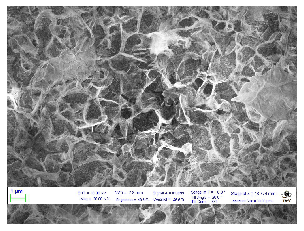

In [33]:
p = Path(f'../data/Processed_Data/Labelled/{subdir}/More_Preprocessing')
filename = 'L3_3ac603c56dd9647a7e8c17b36618084a.jpg'
filepath = p/f'{filename}'

img = mpimg.imread(filepath)
plt.imshow(img)
plt.axis('off')

(-0.5, 1023.5, 767.5, -0.5)

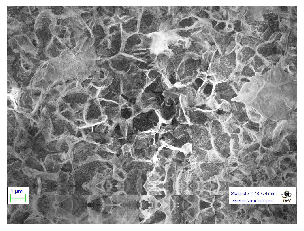

In [34]:
bannerless = remove_banners(img, threshold = 254)
seg, num_seg = apply_watershed(bannerless)
plt.imshow(bannerless)
plt.axis('off')